In [1]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
import prettytable as pt
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")



###################################################################################################
                                                                                                  #
from rhoova.Client import *                                                                       #   
#Register and get api key from https://app.rhoova.com/ for ClientConfig("api key", "api secret")  #
config = ClientConfig("", "")                #                                                    #
api = Api(config)                                                                                 # 
                                                                                                  #
###################################################################################################


directory = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + os.pardir)
yielddatadirectory=directory+"/data/yielddata/bonddefiniton.csv"
marketdatadirectory=directory+"/data/marketdata/marketdata.csv"


bonddefiniton = pd.read_csv(yielddatadirectory)
marketdata = pd.read_csv(marketdatadirectory)

data=bonddefiniton.merge(marketdata[['valuationDate','isinCode','value']], left_on='isinCode', right_on='isinCode')


In [2]:
# Rhoova expects date,convention,calendar input  as a string. Frequency values are Semiannual, Annual etc.
#6M,1Y cant be accepted.All inputs for fixedratebond are in https://app.rhoova.com/docs#post-/tasks/fixed-rate-bond

#Create empty dictionary to fill bond definition. Dictionary name is not case sensitive.
#It has to be define fixedRateBondDefinition

floatingBondDefinition={}
floatingBondDefinition["issueDate"]="2015-07-15"
floatingBondDefinition["maturityDate"]="2025-07-15"
floatingBondDefinition["frequency"]="Semiannual"
floatingBondDefinition["spread"]=0.0
floatingBondDefinition["calendar"]="Turkey"
floatingBondDefinition["currency"]="TRY"
floatingBondDefinition["dateGeneration"]="Backward"
floatingBondDefinition["dayCounter"]="Actual360"
floatingBondDefinition["businessDayConvention"]="ModifiedFollowing"
floatingBondDefinition["maturityDateConvention"]="ModifiedFollowing"
floatingBondDefinition["redemption"]=100
floatingBondDefinition["endOfMonth"]=True
floatingBondDefinition

{'issueDate': '2015-07-15',
 'maturityDate': '2025-07-15',
 'frequency': 'Semiannual',
 'spread': 0.0,
 'calendar': 'Turkey',
 'currency': 'TRY',
 'dateGeneration': 'Backward',
 'dayCounter': 'Actual360',
 'businessDayConvention': 'ModifiedFollowing',
 'maturityDateConvention': 'ModifiedFollowing',
 'redemption': 100,
 'endOfMonth': True}

In [3]:
instruments={}
bonds={}
bonds["settlementDays"]=2
instruments["BONDS"]=bonds
instruments

{'BONDS': {'settlementDays': 2}}

In [4]:
#Define discount curve parameter for pricing bonds.
discountCurve={}
discountCurve["settlementDays"]=2
discountCurve["calendar"]="Turkey" 
discountCurve["currency"]="USD" # Currency is using filter yield data. Only same currency datas are filtered for bond calculation
discountCurve["dayCounter"]="Actual360" # Default value is Actual360
discountCurve["period"]="6M" # Can not use if instruments selected BONDS
discountCurve["intpMethod"]="Linear" # if method is not null, it will not used
discountCurve["instruments"]=instruments
discountCurve

{'settlementDays': 2,
 'calendar': 'Turkey',
 'currency': 'USD',
 'dayCounter': 'Actual360',
 'period': '6M',
 'intpMethod': 'Linear',
 'instruments': {'BONDS': {'settlementDays': 2}}}

In [5]:
# Fill bond trade information
positiondata={}
positiondata["notional"]=100
positiondata["valuationDate"]="2021-03-05"
positiondata["settlementDate"]="2021-03-09"
positiondata["buySell"]="Sell"
positiondata

{'notional': 100,
 'valuationDate': '2021-03-05',
 'settlementDate': '2021-03-09',
 'buySell': 'Sell'}

In [6]:
#Join all data
positiondata["floatingBondDefinition"]=floatingBondDefinition
positiondata["discountCurve"]=discountCurve
positiondata["yieldData"]=data.to_dict('r')


In [7]:
try:
    bondresult = api.createTask(CalculationType.FLOATING_RATE_BOND, positiondata,True)
    result=json.loads(bondresult["result"])
except RhoovaError as e:
    e.printPretty()    

In [8]:
npvTable = pt.PrettyTable(['Parameters', 'Value'])
npvTable.add_row(['PV', result.get('pv')])
npvTable.add_row(['Clean Price', result.get('cleanPrice')])
npvTable.add_row(['Dirty Price', result.get('dirtyPrice')])
npvTable.add_row(['Accrued Amount', result.get('accruedAmount')])
npvTable.add_row(['Yield to Maturity', 100*result.get('yieldToMaturity')])
npvTable.add_row(['Duration', result.get('duration')])
npvTable.add_row(['Modified Duration', result.get('modifiedDuration')])
npvTable.add_row(['Macualay Duration', result.get('macaulayDuration')])
npvTable.add_row(['Convexity', result.get('convexity')])
npvTable.add_row(['Bps', result.get('bps')])
npvTable.align = 'r'
npvTable.float_format = '.3'
print(npvTable)



+-------------------+---------+
|        Parameters |   Value |
+-------------------+---------+
|                PV | 100.000 |
|       Clean Price | 100.000 |
|       Dirty Price | 100.000 |
|    Accrued Amount |       0 |
| Yield to Maturity |   4.727 |
|          Duration |   4.101 |
| Modified Duration |   4.006 |
| Macualay Duration |   4.101 |
|         Convexity |  18.675 |
|               Bps |   0.039 |
+-------------------+---------+


In [9]:
cashflow=pd.DataFrame(result.get("data"))
cashflow=cashflow[cashflow["termToMatByDay"]>0]

In [10]:
discountCurve['applyShock']={
  "method": "parallel",
  "shockValues" : [
    {
      "tenor" : "all",
      "shockValue" : 100.0
    }
  ]
}

In [11]:
positiondata["discountCurve"]=discountCurve

In [12]:
try:
    bondresult = api.createTask(CalculationType.FLOATING_RATE_BOND, positiondata,True)
    resultwithshock=json.loads(bondresult["result"])
except RhoovaError as e:
    e.printPretty() 

In [13]:
npvTable = pt.PrettyTable(['Parameters', 'Value'])
npvTable.add_row(['PV', resultwithshock.get('pv')])
npvTable.add_row(['Clean Price', resultwithshock.get('cleanPrice')])
npvTable.add_row(['Dirty Price', resultwithshock.get('dirtyPrice')])
npvTable.add_row(['Accrued Amount', resultwithshock.get('accruedAmount')])
npvTable.add_row(['Yield to Maturity', 100*resultwithshock.get('yieldToMaturity')])
npvTable.add_row(['Duration', resultwithshock.get('duration')])
npvTable.add_row(['Modified Duration', resultwithshock.get('modifiedDuration')])
npvTable.add_row(['Macualay Duration', resultwithshock.get('macaulayDuration')])
npvTable.add_row(['Convexity', resultwithshock.get('convexity')])
npvTable.add_row(['Bps', resultwithshock.get('bps')])
npvTable.align = 'r'
npvTable.float_format = '.3'
print(npvTable)



+-------------------+---------+
|        Parameters |   Value |
+-------------------+---------+
|                PV | 100.000 |
|       Clean Price | 100.000 |
|       Dirty Price | 100.000 |
|    Accrued Amount |       0 |
| Yield to Maturity |   5.738 |
|          Duration |   4.026 |
| Modified Duration |   3.913 |
| Macualay Duration |   4.026 |
|         Convexity |  18.035 |
|               Bps |   0.039 |
+-------------------+---------+


https://www.theice.com/publicdocs/futures/Price_Sensitivity.pdf

In [14]:
BPV=result.get('dirtyPrice')-resultwithshock.get('dirtyPrice')
BPV

5.684341886080802e-14

In [15]:
BPV=result.get('modifiedDuration')*result.get('dirtyPrice')*0.0001
BPV

0.040059577170559385

In [16]:
shockedcashflow=pd.DataFrame(resultwithshock.get("data"))
shockedcashflow=shockedcashflow[shockedcashflow["termToMatByDay"]>0]

In [17]:
zerorates=cashflow[["accrualEnd","zeroRate"]]
zerorates.drop(zerorates.tail(1).index,inplace=True) # drop last rows
shockedzerorates=shockedcashflow[["accrualEnd","zeroRate"]]
shockedzerorates.columns=["accrualEnd","shockedzeroRate"]
shockedzerorates.drop(shockedzerorates.tail(1).index,inplace=True) # drop last rows

In [18]:
rates=pd.merge(zerorates, shockedzerorates, on=["accrualEnd", "accrualEnd"])
rates

,accrualEnd,zeroRate,shockedzeroRate
0,2021-07-16,0.020285,0.030285
1,2022-01-17,0.026421,0.036421
2,2022-07-18,0.031710,0.041710
3,2023-01-16,0.034450,0.044450
4,2023-07-17,0.037473,0.047473
5,2024-01-15,0.041276,0.051276
6,2024-07-16,0.043768,0.053768
7,2025-01-15,0.045349,0.055349
8,2025-07-16,0.047402,0.057402


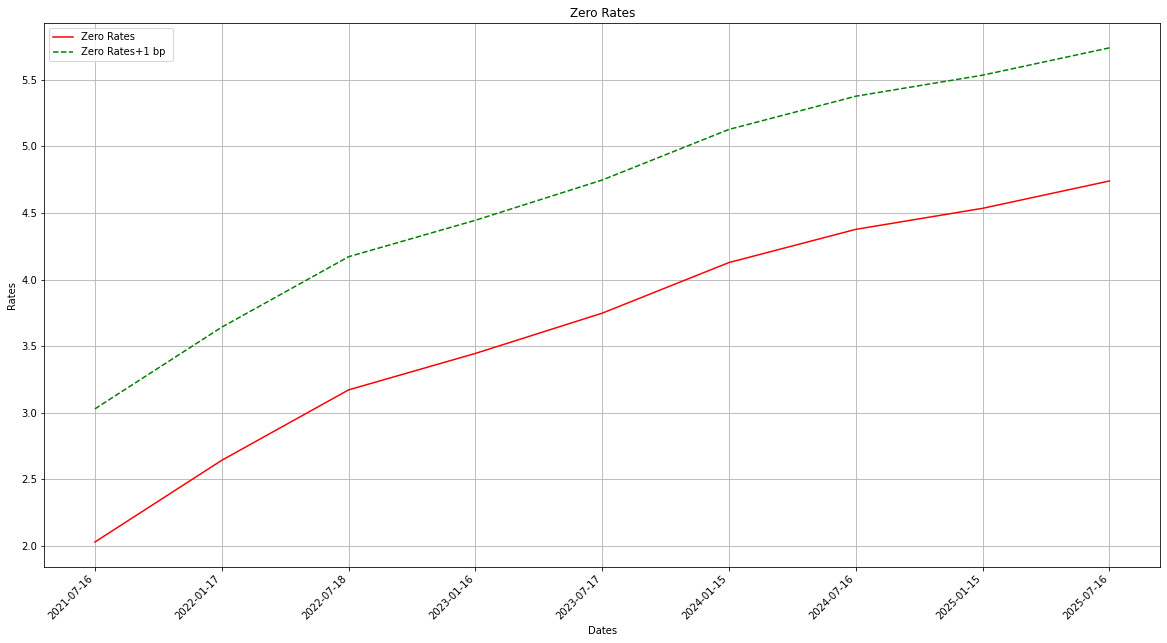

In [19]:
dates=list(rates["accrualEnd"])
zerorate=list(rates["zeroRate"]*100)
shockedzerorate=list(rates["shockedzeroRate"]*100)


fig, ax = plt.subplots(figsize=(20, 10))
#ax.plot(rates, list(result),label='YielChange',c='b')
ax.plot(dates, zerorate,label='Zero Rates',c='r')
ax.plot(dates, shockedzerorate,ls='--',label='Zero Rates+1 bp ',c='g')
ax.set(xlabel='Dates', ylabel='Rates',
       title='Zero Rates')
ax.grid()
plt.xticks(rotation=45, ha='right')
plt.legend(loc=2)
plt.show()